___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://http2.mlstatic.com/D_NQ_NP_2X_960089-MLM26807621582_022018-F.webp" width="350px" height="180px" />


# <font color= #8A0829> Data modelling lab </font>
- <Strong> Teacher: Sara Eugenia Rodríguez </Strong>
- <Strong> Year </Strong>: 2023



### <font color= #2E9AFE> Feature selection</font>

Feature selection is a process where features that impact the most are automatically selected


Irrelevant features migth negativelly affect the model

Benefits:
- Reduce overfitting
- Model is easier to understand
- Reduce training time


**Types of feature selection**


    - **Wrappers**: Different feature combinations are prepared, tested and evaluated when creating a model with those

        -   Example: RFE

    - **Filtering methods**: This method apply an statistic measure to assign a score to each feature. Features are ranked based on the score
        - Examples: Variances, correlation, Squared chi, L-Anova


    - **Embeed methods** The model itself based let us know most important features
        - Example: LASSO, RIDGE, Elastic Net, Trees

<img src="https://machinelearningmastery.com/wp-content/uploads/2019/11/Overview-of-Feature-Selection-Techniques3.png" width="550" height="480" align="center"/>


**Most common techniques**

- Null values percentage
- Variance amount
- Pair correlation
- Multicolinearity
- PCA
- Correlation with target value 
- Forward selection
- Stepwise selection
- LASSO
- Tree based selection

#### Datos: Glass Identification Data Set
Data can be found :
https://archive.ics.uci.edu/ml/datasets/glass+identification

Se busca identificar qué tipo de vidrio es una muestra. 
We want to identify which glass type is each sample


- 1. Id number: 1 a 214
- 2. RI: Refractive index
- 3. Na: Sodium
- 4. Mg: Magneisum
- 5. Al: Aliminium
- 6. Si: Silicon
- 7. K: Potasium
- 8. Ca: Calcium
- 9. Ba: Barium
- 10. Fe: Iron
- 11. Glass type: 



In [1]:
#Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load glass data
data = pd.read_csv('glass.data',header=None)
names = ['ID','refraction_index','Na','Mg','Al','Si','K', 'Ca','Ba','Fe','Tipo_Vidrio']
data.columns = names

In [2]:
data.head()

,ID,refraction_index,Na,Mg,Al,Si,K,Ca,Ba,Fe,Tipo_Vidrio
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


# Filtering methods

### Eliminating features with ccertain % of null values

1. Take out variables that have a high % of null values
   

## Correlation between pairs criteria (without takink in consideration target variable)

$$y=\beta_{0}+\beta_{1}X_{1}+\beta_{2}X_{2}+...+\epsilon$$


when there is correlation between 2 predictors, we can't determine the efect from 1 variable,because both variables change together

So, when we have correlation between 2 predictors we can consider that each one give us the same information to the model, So it's prefferable to chosse features that are not correlatied and avoid "duplicated" data

If 2 variables are strongly correlated , we can keep just one and reduce dimensionality without losing lot of information


In [3]:
#Split X and Y
X = data.iloc[:,1:10]
Y = data.iloc[:,10]
co= round(X.corr(),2)
co.style.background_gradient(cmap='coolwarm')

,refraction_index,Na,Mg,Al,Si,K,Ca,Ba,Fe
refraction_index,1.000000,-0.190000,-0.120000,-0.410000,-0.540000,-0.290000,0.810000,-0.000000,0.140000
Na,-0.190000,1.000000,-0.270000,0.160000,-0.070000,-0.270000,-0.280000,0.330000,-0.240000
Mg,-0.120000,-0.270000,1.000000,-0.480000,-0.170000,0.010000,-0.440000,-0.490000,0.080000
Al,-0.410000,0.160000,-0.480000,1.000000,-0.010000,0.330000,-0.260000,0.480000,-0.070000
Si,-0.540000,-0.070000,-0.170000,-0.010000,1.000000,-0.190000,-0.210000,-0.100000,-0.090000
K,-0.290000,-0.270000,0.010000,0.330000,-0.190000,1.000000,-0.320000,-0.040000,-0.010000
Ca,0.810000,-0.280000,-0.440000,-0.260000,-0.210000,-0.320000,1.000000,-0.110000,0.120000
Ba,-0.000000,0.330000,-0.490000,0.480000,-0.100000,-0.040000,-0.110000,1.000000,-0.060000
Fe,0.140000,-0.240000,0.080000,-0.070000,-0.090000,-0.010000,0.120000,-0.060000,1.000000


In [4]:
def calcDrop(res):
    # Obtener todas las variables con una correlacion  > 0.6
    all_corr_vars = list(set(res['v1'].tolist() + res['v2'].tolist()))
    
    # Todas las variables únicas en las columnas a remover
    poss_drop = list(set(res['drop'].tolist()))

    # Quedarse con las variables que no estén en las variables a remover
    keep = list(set(all_corr_vars).difference(set(poss_drop)))
     
    p = res[ res['v1'].isin(keep)  | res['v2'].isin(keep) ][['v1', 'v2']]
    q = list(set(p['v1'].tolist() + p['v2'].tolist()))
    drop = (list(set(q).difference(set(keep))))

    poss_drop = list(set(poss_drop).difference(set(drop)))
    
    m = res[ res['v1'].isin(poss_drop)  | res['v2'].isin(poss_drop) ][['v1', 'v2','drop']]
        
    more_drop = set(list(m[~m['v1'].isin(drop) & ~m['v2'].isin(drop)]['drop']))
    for item in more_drop:
        drop.append(item)
         
    return drop


def corrX_new(df, cut = 0.6) :
       
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(bool))
    
    dropcols = list()
    
    res = pd.DataFrame(columns=(['v1', 'v2', 'v1.target', 
                                 'v2.target','corr', 'drop' ]))
    
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    dropcols.append(row)
                    drop = corr_mtx.columns[row]
                else: 
                    dropcols.append(col)
                    drop = corr_mtx.columns[col]
                
                s = pd.Series([ corr_mtx.index[row],
                up.columns[col],
                avg_corr[row],
                avg_corr[col],
                up.iloc[row,col],
                drop],
                index = res.columns)
        
                res = res.append(s, ignore_index = True)
    
    dropcols_names = calcDrop(res)
    
    return(dropcols_names)

drop = corrX_new(X)
print(drop)

['Ca']


/var/folders/8q/9zk58sl93rx81t6np6mvjx200000gn/T/ipykernel_1291/2542785647.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(s, ignore_index = True)


Only variable we can remoe is calcium

In [5]:
X_no_corr = X.drop(columns=['Ca'], axis=1)

In [6]:
co= X_no_corr.corr()
co.style.background_gradient(cmap='coolwarm').format(precision=1)

,refraction_index,Na,Mg,Al,Si,K,Ba,Fe
refraction_index,1.0,-0.2,-0.1,-0.4,-0.5,-0.3,-0.0,0.1
Na,-0.2,1.0,-0.3,0.2,-0.1,-0.3,0.3,-0.2
Mg,-0.1,-0.3,1.0,-0.5,-0.2,0.0,-0.5,0.1
Al,-0.4,0.2,-0.5,1.0,-0.0,0.3,0.5,-0.1
Si,-0.5,-0.1,-0.2,-0.0,1.0,-0.2,-0.1,-0.1
K,-0.3,-0.3,0.0,0.3,-0.2,1.0,-0.0,-0.0
Ba,-0.0,0.3,-0.5,0.5,-0.1,-0.0,1.0,-0.1
Fe,0.1,-0.2,0.1,-0.1,-0.1,-0.0,-0.1,1.0


There are no longer X variables strongly correlated

## Elimination methods taking in consideration X and Y

## Correlation with Y criteria

- Eliminar variables que tienen una correlación baja con la variable a predecir
- Eliminate variales with weak correlation with output variable


In [7]:
co= data.iloc[:,1:11].corr()
co.style.background_gradient(cmap='coolwarm').format(precision=1)

,refraction_index,Na,Mg,Al,Si,K,Ca,Ba,Fe,Tipo_Vidrio
refraction_index,1.0,-0.2,-0.1,-0.4,-0.5,-0.3,0.8,-0.0,0.1,-0.2
Na,-0.2,1.0,-0.3,0.2,-0.1,-0.3,-0.3,0.3,-0.2,0.5
Mg,-0.1,-0.3,1.0,-0.5,-0.2,0.0,-0.4,-0.5,0.1,-0.7
Al,-0.4,0.2,-0.5,1.0,-0.0,0.3,-0.3,0.5,-0.1,0.6
Si,-0.5,-0.1,-0.2,-0.0,1.0,-0.2,-0.2,-0.1,-0.1,0.2
K,-0.3,-0.3,0.0,0.3,-0.2,1.0,-0.3,-0.0,-0.0,-0.0
Ca,0.8,-0.3,-0.4,-0.3,-0.2,-0.3,1.0,-0.1,0.1,0.0
Ba,-0.0,0.3,-0.5,0.5,-0.1,-0.0,-0.1,1.0,-0.1,0.6
Fe,0.1,-0.2,0.1,-0.1,-0.1,-0.0,0.1,-0.1,1.0,-0.2
Tipo_Vidrio,-0.2,0.5,-0.7,0.6,0.2,-0.0,0.0,0.6,-0.2,1.0


# Wrapping methods

### Recursive feature elimination

Works by recursively eliminating attributes and building models with attributes that are left
It uses model accuracy to identify which attributes combination contributes the most to predict the object
We're going to uses logistic regression to select the 4 main features. 

In [9]:
#RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


model = LogisticRegression()


rfe = RFE(model)

#Fitting model
fit = rfe.fit(X, Y)
print("# of features: %d" % fit.n_features_)
print("Selected features: %s" % fit.support_)



# of features: 4
Selected features: [False False  True  True False  True False  True False]


/Users/octavioperezurbina/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/octavioperezurbina/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

In [10]:
data.head()

,ID,refraction_index,Na,Mg,Al,Si,K,Ca,Ba,Fe,Tipo_Vidrio
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [11]:
X.loc[:, fit.support_]

,Mg,Al,K,Ba
0,4.49,1.10,0.06,0.00
1,3.60,1.36,0.48,0.00
2,3.55,1.54,0.39,0.00
3,3.69,1.29,0.57,0.00
4,3.62,1.24,0.55,0.00
...,...,...,...,...
209,0.00,2.88,0.08,1.06
210,0.00,1.99,0.00,1.59
211,0.00,2.02,0.00,1.64
212,0.00,1.94,0.00,1.57


RFE choosed the following variablesMg, Al, K, Ba 

# Embeeded methods

### Feature selection based on trees

Tree based models like "random forest" already have a feature selection method internally where we know attribute importance

In [12]:
#Random forest feature imoortance
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier()

#Fit the model
model.fit(X, Y)

importances = pd.DataFrame(data={
    'Attribute':data.iloc[:,1:10].columns, 
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances

,Attribute,Importance
2,Mg,0.156760
3,Al,0.154867
0,refraction_index,0.152417
6,Ca,0.125073
1,Na,0.104262
5,K,0.092463
4,Si,0.088932
7,Ba,0.079302
8,Fe,0.045924


4 most aimportant values are Mg, Al, Ca and refraction_index

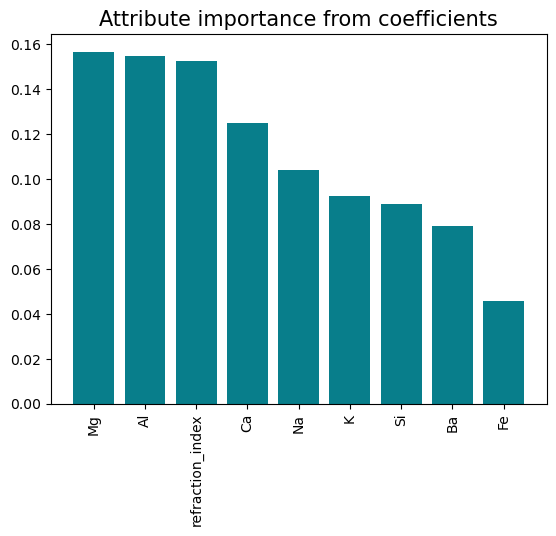

In [13]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Attribute importance from coefficients', size=15)
plt.xticks(rotation='vertical')
plt.show()

### Least Absolute Shrinkage and Selection Operator (LASSO)

LASSO algorithm has a regularization parameter that penalizes some variables and make them 0

In [14]:
#Train-test split
X= data.drop(labels=['ID', 'Tipo_Vidrio'], axis=1)
Y= data['Tipo_Vidrio']

In [15]:
data.head()

,ID,refraction_index,Na,Mg,Al,Si,K,Ca,Ba,Fe,Tipo_Vidrio
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Most models are benefit from scaling the data

In [16]:
#Scalling train data
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [17]:
##LASSO
from sklearn.feature_selection import SelectFromModel
sel=LogisticRegression(C=1, penalty='l1', solver='liblinear').fit(X,Y) #LASSO  = L1
sel=SelectFromModel(sel, prefit=True) #Feature selection
X_new=sel.transform(X)
X_new.shape

/Users/octavioperezurbina/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/octavioperezurbina/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(214, 8)

In [18]:
pd.DataFrame(X_new)

,0,1,2,3,4,5,6,7
0,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0
1,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0
2,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0
3,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0
4,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0
...,...,...,...,...,...,...,...,...
209,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0
210,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0
211,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0
212,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0


In [19]:
X.head()

,refraction_index,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


Model took out refraction_index feature

### References:

- Comparison of F-test and mutual information: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py
- Feature selection: https://scikit-learn.org/stable/modules/feature_selection.html


<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Sara E. Rodríguez.
</footer>